In [92]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os 
from warnings import simplefilter
import pandas as pd
from imblearn.over_sampling import SMOTE

In [93]:
import models
import class_sampling
import train
import metric_utils
import inference
import loss_fns
import torchvision.ops 

In [94]:
NUM_CLASSES = 10
n_epochs = 50
batch_size_train = 64
batch_size_test = 1000
momentum = 0

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

NUM_CLASSES_REDUCED = 2
nums = (0, 1)
ratio = (100, 1)

CLASS_LABELS = {'airplane': 0,
                 'automobile': 1,
                 'bird': 2,
                 'cat': 3,
                 'deer': 4,
                 'dog': 5,
                 'frog': 6,
                 'horse': 7,
                 'ship': 8,
                 'truck': 9}


simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)
simplefilter(action='ignore', category=DeprecationWarning)

In [95]:
# name, num_classes, classes used, ratio, learning rate, mean 10, variance 10, mean 20, variance 20, ... 50

# mean, variance every 10 epochs - average of 10 models 
# name, num_classes, classes used, ratio, learning rate, mean 10, variance 10, mean 20, variance 20, ... 50
# name: normal/ratio/oversampled/undersampled/weighted

col_names = ["name", 
            "num_classes", 
            "classes_used", 
            "ratio", 
            "learning_rate", 
            "mean_0", "variance_0",
            "mean_10", "variance_10",
            "mean_20", "variance_20",
            "mean_30", "variance_30",
            "mean_40", "variance_40",
            "mean_50", "variance_50"]

rows = []

In [96]:
train_CIFAR10 = torchvision.datasets.CIFAR10('cifar10', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor() ]))  


test_CIFAR10 = torchvision.datasets.CIFAR10('cifar10', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()]))

train_CIFAR10.data = train_CIFAR10.data.reshape(50000, 3, 32, 32)
test_CIFAR10.data = test_CIFAR10.data.reshape(10000, 3, 32, 32)

    
reduced_train_CIFAR10 = class_sampling.Reduce(train_CIFAR10, NUM_CLASSES_REDUCED, nums=nums, CIFAR=True)
reduced_test_CIFAR10 = class_sampling.Reduce(test_CIFAR10, NUM_CLASSES_REDUCED, nums=nums, CIFAR=True)

ratio_train_CIFAR10 = class_sampling.Ratio(train_CIFAR10, NUM_CLASSES_REDUCED, ratio, nums=nums)

smote_train_CIFAR10 = class_sampling.Smote(ratio_train_CIFAR10)

Files already downloaded and verified
Files already downloaded and verified


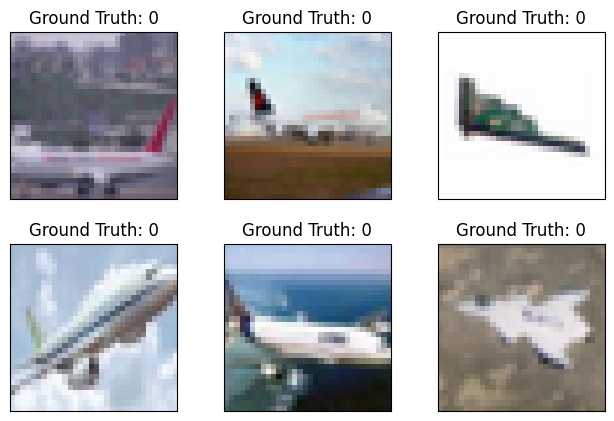

In [100]:
examples = smote_train_CIFAR10.images
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(examples[i].reshape(32, 32, 3).int())
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [13]:
targets = ratio_train_CIFAR10.labels 

class_count = np.unique(targets, return_counts=True)[1]
print(class_count)

weight = 1. / class_count

samples_weight = weight[targets]
samples_weight = torch.from_numpy(samples_weight)
oversampler = torch.utils.data.WeightedRandomSampler(samples_weight, int(max(class_count) * NUM_CLASSES_REDUCED), replacement=True)
sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)
undersampler = torch.utils.data.WeightedRandomSampler(samples_weight, int(min(class_count) * NUM_CLASSES_REDUCED), replacement=False)

weight *= class_count[0]

[5000   50]


In [14]:
beta = 0.999 

exp = np.empty_like(targets)
for i, count in enumerate(class_count):
    exp[targets==i] = count
effective_weights = (1 - beta) / ( 1 - (beta ** torch.from_numpy(exp)))

In [15]:
print(effective_weights)

tensor([0.0010, 0.0010, 0.0010,  ..., 0.0205, 0.0205, 0.0205])


In [36]:
train_loader_reduced = DataLoader(reduced_train_CIFAR10, batch_size=batch_size_train, shuffle=True)  

train_loader_ratio = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, shuffle=True) 

train_loader_oversampled = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, sampler=oversampler)

train_loader_undersampled = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, sampler=undersampler)

train_loader_sampled = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, sampler=sampler)

train_loader_smote = DataLoader(smote_train_CIFAR10, batch_size=batch_size_train, shuffle=True)

test_loader_reduced = DataLoader(reduced_test_CIFAR10, batch_size=batch_size_test, shuffle=True)

In [37]:
print(test_loader_reduced.dataset.images.shape) # tupe instead of torch.Size() like the others 

torch.Size([2000, 3, 32, 32])


IndexError: index 5050 is out of bounds for dimension 0 with size 64

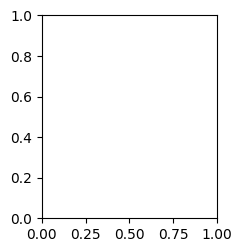

In [60]:
examples = enumerate(train_loader_smote) # enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i].reshape(32, 32, 3).int())
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [12]:
# SIGMOID 2 CLASS normal AUC saving  

momentum=0
learning_rates = [2e-5, 3e-5, 5e-5, 7e-5, 9e-5]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_reduced, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)
   


Test set: Avg. loss: 0.024605756759643556, AUC: 0.6469975


Test set: Avg. loss: 0.014931785106658936, AUC: 0.8215375


Test set: Avg. loss: 0.051244140625, AUC: 0.75086


Test set: Avg. loss: 0.12066669464111328, AUC: 0.5902445000000001


Test set: Avg. loss: 0.06057313537597656, AUC: 0.7290795


Test set: Avg. loss: 0.016814103603363037, AUC: 0.8081860000000001


Test set: Avg. loss: 0.020942140579223632, AUC: 0.459742


Test set: Avg. loss: 0.13868421936035155, AUC: 0.504016


Test set: Avg. loss: 0.012890518665313721, AUC: 0.8556889999999999


Test set: Avg. loss: 0.04611336135864258, AUC: 0.6312180000000001


Test set: Avg. loss: 0.020766493797302246, AUC: 0.858468


Test set: Avg. loss: 0.021261009216308593, AUC: 0.8546545000000001


Test set: Avg. loss: 0.04852569198608398, AUC: 0.59049


Test set: Avg. loss: 0.05658713340759278, AUC: 0.7340209999999999



KeyboardInterrupt: 

In [ ]:
print(learning_rate_aucs.shape)
auc_mean = np.mean(learning_rate_aucs, axis=1)
print(auc_mean.shape)
auc_variance = np.var(learning_rate_aucs, axis=1)
print(auc_variance.shape)

for i in range(len(learning_rates)): 
    row = ["normal", 2, nums, (1, 1), learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)

print(rows)

# pd.DataFrame(rows, columns = col_names) 

In [13]:
# SIGMOID 2 CLASS ratio

momentum=0
learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(2, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_ratio, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["ratio", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)



Test set: Avg. loss: 0.03197626209259033, AUC: 0.4619719999999998


Test set: Avg. loss: 0.014868484020233155, AUC: 0.731327


Test set: Avg. loss: 0.02078729820251465, AUC: 0.765631


Test set: Avg. loss: 0.01243867301940918, AUC: 0.7592875


Test set: Avg. loss: 0.008404238224029541, AUC: 0.7387854999999999


Test set: Avg. loss: 0.016378780364990235, AUC: 0.7749185000000001


Test set: Avg. loss: 0.062348251342773435, AUC: 0.491014


Test set: Avg. loss: 0.02947155952453613, AUC: 0.772812


Test set: Avg. loss: 0.011246074676513671, AUC: 0.791176


Test set: Avg. loss: 0.013778327465057373, AUC: 0.8004434999999999


Test set: Avg. loss: 0.01350959300994873, AUC: 0.803744



KeyboardInterrupt: 

In [ ]:
# SIGMOID 2 CLASS oversampled

momentum=0
learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(2, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_oversampled, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["oversampled", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


In [ ]:
# SIGMOID 2 CLASS undersampled

momentum=0
learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(2, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_undersampled, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["undersampled", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


In [ ]:
# SIGMOID 2 CLASS over+undersampled

momentum=0
learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(2, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_sampled, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["both_sampled", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


In [ ]:
# SIGMOID 2 CLASS weighted 

momentum=0
learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

loss_fn_args = {}
loss_fn_args['pos_weight'] = torch.tensor([weight[1]])

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(2, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_ratio, network, optimizer, verbose=False, loss_fn_args=loss_fn_args)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["weighted", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


In [21]:
# 2 CLASS Focal Loss 
# no weights (yet)


momentum=0
learning_rates = [1e-3, 1e-4, 5e-4, 1e-5, 5e-5, 1e-6, 5e-7]

learning_rate_aucs = []

loss_fn_args = {}
loss_fn_args['reduction'] = 'mean'


for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(2, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_ratio, network, optimizer, verbose=False, loss_fn=loss_fns.SigmoidFocalLoss, loss_fn_args=loss_fn_args)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["focal_loss", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)



Test set: Avg. loss: 0.02157968044281006, AUC: 0.6867034999999999


Test set: Avg. loss: 0.25539259338378906, AUC: 0.52


Test set: Avg. loss: 0.5048945159912109, AUC: 0.5


Test set: Avg. loss: 0.9401114196777344, AUC: 0.5005


Test set: Avg. loss: 0.21155704498291017, AUC: 0.589535


Test set: Avg. loss: 0.3151288604736328, AUC: 0.540535


Test set: Avg. loss: 0.023658714294433593, AUC: 0.39837999999999996


Test set: Avg. loss: 0.180468505859375, AUC: 0.571037


Test set: Avg. loss: 0.08399776077270507, AUC: 0.6958759999999999


Test set: Avg. loss: 0.16746481323242188, AUC: 0.6145299999999999


Test set: Avg. loss: 1.1457880859375, AUC: 0.5


Test set: Avg. loss: 0.28829020690917967, AUC: 0.55198


Test set: Avg. loss: 0.04466410827636719, AUC: 0.5848144999999999


Test set: Avg. loss: 7.139232666015625, AUC: 0.5


Test set: Avg. loss: 0.5686558227539062, AUC: 0.502


Test set: Avg. loss: 0.10955883407592773, AUC: 0.690185


Test set: Avg. loss: 0.3668731231689453, AUC: 0.51


Tes


Test set: Avg. loss: 2.8143094482421875, AUC: 0.5


Test set: Avg. loss: 1.2145692749023438, AUC: 0.5


Test set: Avg. loss: 2.0932828369140624, AUC: 0.5


Test set: Avg. loss: 0.19784551239013673, AUC: 0.5225339999999999


Test set: Avg. loss: 0.14437006378173828, AUC: 0.5754865


Test set: Avg. loss: 0.024299232482910157, AUC: 0.6556175


Test set: Avg. loss: 0.14648637390136718, AUC: 0.5325259999999999


Test set: Avg. loss: 0.08377293014526367, AUC: 0.63031


Test set: Avg. loss: 2.0941864013671876, AUC: 0.5


Test set: Avg. loss: 0.36805392456054686, AUC: 0.5


Test set: Avg. loss: 0.12643811416625977, AUC: 0.5844545


Test set: Avg. loss: 0.019841660499572755, AUC: 0.461005


Test set: Avg. loss: 0.2676147155761719, AUC: 0.5045000000000001


Test set: Avg. loss: 0.05666688346862793, AUC: 0.7131529999999999


Test set: Avg. loss: 0.5234431915283203, AUC: 0.5


Test set: Avg. loss: 0.06799781799316407, AUC: 0.6953485


Test set: Avg. loss: 0.15751282501220704, AUC: 0.5510320000000


Test set: Avg. loss: 0.07702728271484376, AUC: 0.5258685


Test set: Avg. loss: 0.017853473663330077, AUC: 0.7562289999999999


Test set: Avg. loss: 0.023167854309082032, AUC: 0.7897390000000001


Test set: Avg. loss: 0.015082174301147461, AUC: 0.7945310000000001


Test set: Avg. loss: 0.03468166732788086, AUC: 0.4495929999999999


Test set: Avg. loss: 0.03586968994140625, AUC: 0.7529619999999999


Test set: Avg. loss: 0.12154244232177734, AUC: 0.502993


Test set: Avg. loss: 0.0179623441696167, AUC: 0.8119695


Test set: Avg. loss: 0.07455818176269531, AUC: 0.539934


Test set: Avg. loss: 0.040379995346069335, AUC: 0.746824


Test set: Avg. loss: 0.01720845317840576, AUC: 0.39403199999999994


Test set: Avg. loss: 0.004933303594589234, AUC: 0.7571275000000001


Test set: Avg. loss: 0.01837593936920166, AUC: 0.811898


Test set: Avg. loss: 0.0162269926071167, AUC: 0.8133875


Test set: Avg. loss: 0.011354846954345703, AUC: 0.7839635


Test set: Avg. loss: 0.015536299705505371, AUC: 0.


Test set: Avg. loss: 0.04019078254699707, AUC: 0.6350349999999999


Test set: Avg. loss: 0.03835585212707519, AUC: 0.6323344999999999


Test set: Avg. loss: 0.03742955017089844, AUC: 0.6358940000000001


Test set: Avg. loss: 0.03620248031616211, AUC: 0.6359174999999999


Test set: Avg. loss: 0.04511733245849609, AUC: 0.6412525


Test set: Avg. loss: 0.04101388359069824, AUC: 0.647138


Test set: Avg. loss: 0.03769660568237305, AUC: 0.6524810000000001


Test set: Avg. loss: 0.03643505859375, AUC: 0.6563595


Test set: Avg. loss: 0.03591868019104004, AUC: 0.6615504999999999


Test set: Avg. loss: 0.03551282501220703, AUC: 0.6665095


Test set: Avg. loss: 0.0275010986328125, AUC: 0.45815349999999994


Test set: Avg. loss: 0.02960848045349121, AUC: 0.6919795


Test set: Avg. loss: 0.028941520690917967, AUC: 0.691463


Test set: Avg. loss: 0.027770015716552736, AUC: 0.691391


Test set: Avg. loss: 0.026958831787109373, AUC: 0.691355


Test set: Avg. loss: 0.02633824825286865, AUC: 0.693122

In [44]:
# 2 Class SMOTE 

momentum=0
learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(2, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_smote, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["smote", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)



Test set: Avg. loss: 0.02460575580596924, AUC: 0.6469985


Test set: Avg. loss: 0.026045684814453126, AUC: 0.6504340000000001


Test set: Avg. loss: 0.01497733449935913, AUC: 0.7351255000000001


Test set: Avg. loss: 0.01858936882019043, AUC: 0.6978739999999999


Test set: Avg. loss: 0.020224379539489745, AUC: 0.688307


Test set: Avg. loss: 0.0205801362991333, AUC: 0.8344085000000001


Test set: Avg. loss: 0.02094214153289795, AUC: 0.459742


Test set: Avg. loss: 0.01317272424697876, AUC: 0.838303


Test set: Avg. loss: 0.010728169441223144, AUC: 0.7882945


Test set: Avg. loss: 0.020182360649108888, AUC: 0.835347


Test set: Avg. loss: 0.025778563499450683, AUC: 0.8216855


Test set: Avg. loss: 0.009684601306915282, AUC: 0.8063224999999999


Test set: Avg. loss: 0.048525693893432614, AUC: 0.59049


Test set: Avg. loss: 0.01905726909637451, AUC: 0.700017


Test set: Avg. loss: 0.05620224761962891, AUC: 0.6844739999999999


Test set: Avg. loss: 0.010672938346862794, AUC: 0.8569535


T


Test set: Avg. loss: 0.0027709816694259644, AUC: 0.758486


Test set: Avg. loss: 0.002616809606552124, AUC: 0.758127


Test set: Avg. loss: 0.07548549270629883, AUC: 0.49999600000000005


Test set: Avg. loss: 0.003938430190086365, AUC: 0.725591


Test set: Avg. loss: 0.003295870542526245, AUC: 0.747362


Test set: Avg. loss: 0.003393442630767822, AUC: 0.7736390000000001


Test set: Avg. loss: 0.002863102316856384, AUC: 0.7522115


Test set: Avg. loss: 0.0029881786108016967, AUC: 0.744436


Test set: Avg. loss: 0.027087728500366212, AUC: 0.44866949999999994


Test set: Avg. loss: 0.005449873447418213, AUC: 0.715775


Test set: Avg. loss: 0.003962276101112366, AUC: 0.7225360000000001


Test set: Avg. loss: 0.0035350985527038575, AUC: 0.7281434999999999


Test set: Avg. loss: 0.0036542681455612185, AUC: 0.7106265


Test set: Avg. loss: 0.00295078182220459, AUC: 0.736918


Test set: Avg. loss: 0.02875083065032959, AUC: 0.6469420000000001


Test set: Avg. loss: 0.004768420934677124, AUC: 0


Test set: Avg. loss: 0.009970030784606933, AUC: 0.48227600000000004


Test set: Avg. loss: 0.04632254409790039, AUC: 0.47904500000000005


Test set: Avg. loss: 0.012526666164398194, AUC: 0.582388


Test set: Avg. loss: 0.010988277435302734, AUC: 0.594391


Test set: Avg. loss: 0.009710521221160888, AUC: 0.6040715000000001


Test set: Avg. loss: 0.008653043270111084, AUC: 0.617047


Test set: Avg. loss: 0.007799698352813721, AUC: 0.630919


Test set: Avg. loss: 0.06196899604797363, AUC: 0.5754319999999999


Test set: Avg. loss: 0.0074221229553222655, AUC: 0.6066335


Test set: Avg. loss: 0.006804392099380493, AUC: 0.6222065


Test set: Avg. loss: 0.006396243810653687, AUC: 0.6348889999999999


Test set: Avg. loss: 0.0061254088878631595, AUC: 0.644071


Test set: Avg. loss: 0.005921830415725708, AUC: 0.6511915


Test set: Avg. loss: 0.03369696807861328, AUC: 0.4749055


Test set: Avg. loss: 0.00892920446395874, AUC: 0.5917525


Test set: Avg. loss: 0.008496898174285889, AUC: 0.6023225



In [ ]:
# 2 Class SMOTE with capped loss 

momentum=0
learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []


loss_fn_args = {}
loss_fn_args['smote_labels'] =  
loss_fn_args['loss_cap'] = 1e-3

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(2, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_smote, network, optimizer, verbose=False, loss_fn=loss_fns.CappedBCELoss, loss_fn_args=loss_fn_args)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["capped_smote", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


In [104]:
# 2 class effective # of samples 

momentum=0
learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

loss_fn_args = {}
loss_fn_args['pos_weight'] = effective_weights

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(2, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_ratio, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["effective_samples", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)



Test set: Avg. loss: 0.021182982444763184, AUC: 0.672261


Test set: Avg. loss: 0.02040205478668213, AUC: 0.784783


Test set: Avg. loss: 0.008496701717376709, AUC: 0.7658635


Test set: Avg. loss: 0.010849761486053466, AUC: 0.7865255


Test set: Avg. loss: 0.014077957153320313, AUC: 0.8000940000000001


Test set: Avg. loss: 0.01160053539276123, AUC: 0.7966500000000001


Test set: Avg. loss: 0.01782694339752197, AUC: 0.5028665


Test set: Avg. loss: 0.023290175437927246, AUC: 0.7743450000000001


Test set: Avg. loss: 0.020170438766479493, AUC: 0.7914720000000001


Test set: Avg. loss: 0.0160395770072937, AUC: 0.780689


Test set: Avg. loss: 0.0165785551071167, AUC: 0.7878360000000001


Test set: Avg. loss: 0.015160138607025147, AUC: 0.78366


Test set: Avg. loss: 0.05102617263793945, AUC: 0.5758955


Test set: Avg. loss: 0.02155221652984619, AUC: 0.765247


Test set: Avg. loss: 0.008215628385543823, AUC: 0.7573829999999999


Test set: Avg. loss: 0.010915471076965331, AUC: 0.7642705000

KeyboardInterrupt: 

In [6]:
NUM_CLASSES_REDUCED = 3
nums = (0, 3, 1)
ratio = (200, 20, 1)


reduced_train_CIFAR10 = class_sampling.Reduce(train_CIFAR10, NUM_CLASSES_REDUCED, nums=nums, CIFAR=True)
reduced_test_CIFAR10 = class_sampling.Reduce(test_CIFAR10, NUM_CLASSES_REDUCED, nums=nums, CIFAR=True)

ratio_train_CIFAR10 = class_sampling.Ratio(train_CIFAR10, NUM_CLASSES_REDUCED, ratio, nums=nums)
targets = ratio_train_CIFAR10.labels 
class_count = np.unique(targets, return_counts=True)[1]

smote_train_CIFAR10 = class_sampling.Smote(ratio_train_CIFAR10)


weight = 1. / class_count
samples_weight = weight[targets]
samples_weight = torch.from_numpy(samples_weight)
oversampler = torch.utils.data.WeightedRandomSampler(samples_weight, int(max(class_count) * NUM_CLASSES_REDUCED), replacement=True)
sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)
undersampler = torch.utils.data.WeightedRandomSampler(samples_weight, int(min(class_count) * NUM_CLASSES_REDUCED), replacement=False)

weight *= max(class_count)


train_loader_reduced = DataLoader(reduced_train_CIFAR10, batch_size=batch_size_train, shuffle=True)  

train_loader_ratio = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, shuffle=True) 

train_loader_oversampled = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, sampler=oversampler)

train_loader_undersampled = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, sampler=undersampler)

train_loader_sampled = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, sampler=sampler)

train_loader_smote = DataLoader(smote_train_CIFAR10, batch_size=batch_size_train, shuffle=True)

test_loader_reduced = DataLoader(reduced_test_CIFAR10, batch_size=batch_size_test, shuffle=True)

In [7]:
# Softmax 3 class normal

learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_reduced, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["normal", 3, nums, (1, 1), learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)



Test set: Avg. loss: 0.029016796747843424, AUC: 0.512664


Test set: Avg. loss: 0.12362478892008463, AUC: 0.5425


Test set: Avg. loss: 0.0237501106262207, AUC: 0.6890000000000001


Test set: Avg. loss: 0.028362667719523112, AUC: 0.661


Test set: Avg. loss: 0.027204696655273437, AUC: 0.68075


Test set: Avg. loss: 0.057541033426920574, AUC: 0.55625


Test set: Avg. loss: 0.033389368693033855, AUC: 0.5614167499999999


Test set: Avg. loss: 0.07811309560139974, AUC: 0.52025


Test set: Avg. loss: 0.04119581731160482, AUC: 0.598


Test set: Avg. loss: 0.05999888737996419, AUC: 0.5587500000000001


Test set: Avg. loss: 0.061533856709798176, AUC: 0.6505


Test set: Avg. loss: 0.039205940246582034, AUC: 0.7025


Test set: Avg. loss: 0.10757938893636068, AUC: 0.54775


Test set: Avg. loss: 0.052771939595540364, AUC: 0.65775


Test set: Avg. loss: 0.06673320007324218, AUC: 0.62325


Test set: Avg. loss: 0.07701803588867187, AUC: 0.5222500000000001


Test set: Avg. loss: 0.02959756088256836, 

KeyboardInterrupt: 

In [ ]:
# Softmax 3 class ratio

learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_ratio, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["ratio", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


In [16]:
# Softmax 3 class oversampled

learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_oversampled, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["oversampled", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)



Test set: Avg. loss: 0.01764530849456787, AUC: 0.5389999999999999


Test set: Avg. loss: 0.035015865325927736, AUC: 0.6815


Test set: Avg. loss: 0.05701504135131836, AUC: 0.611


Test set: Avg. loss: 0.0557035026550293, AUC: 0.6060000000000001


Test set: Avg. loss: 0.06728232192993164, AUC: 0.5825



KeyboardInterrupt: 

In [ ]:
# Softmax 3 class undersampled

learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_undersampled, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["undersampled", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


In [ ]:
# Softmax 3 class both sampled

learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_sampled, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["both_sampled", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


In [ ]:
# Softmax 3 class weighted

learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

loss_fn_args={}
loss_fn_args['weight'] = torch.from_numpy(class_weights).float()

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_ratio, network, optimizer, verbose=False, loss_fn_args=loss_fn_args)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["weighted", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


In [10]:
# Softmax 3 class focal loss 

learning_rates = [1e-3, 1e-4, 5e-4, 1e-5, 5e-5, 1e-6, 5e-7]

learning_rate_aucs = []

loss_fn_args={}
loss_fn_args['reduction'] = 'mean'

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_ratio, network, optimizer, verbose=False, loss_fn=loss_fns.SoftmaxFocalLoss, loss_fn_args=loss_fn_args)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["focal_loss", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)



Test set: Avg. loss: 0.021192817052205402, AUC: 0.4998545


Test set: Avg. loss: 46.84014453125, AUC: 0.5


Test set: Avg. loss: 8.155067708333334, AUC: 0.50975


Test set: Avg. loss: 25.784237630208334, AUC: 0.5


Test set: Avg. loss: 21.013444010416666, AUC: 0.5


Test set: Avg. loss: 2.2271815592447917, AUC: 0.647511


Test set: Avg. loss: 0.02458227729797363, AUC: 0.4927750000000001


Test set: Avg. loss: 1.2777367350260416, AUC: 0.53232075


Test set: Avg. loss: 20.985467447916665, AUC: 0.50025


Test set: Avg. loss: 2.506778076171875, AUC: 0.643527


Test set: Avg. loss: 3.30812060546875, AUC: 0.5106235000000001


Test set: Avg. loss: 3.1348290201822917, AUC: 0.6364495


Test set: Avg. loss: 0.08998995463053386, AUC: 0.59325


Test set: Avg. loss: 3.030626708984375, AUC: 0.6094999999999999


Test set: Avg. loss: 12.6286962890625, AUC: 0.50175


Test set: Avg. loss: 1.0780894165039063, AUC: 0.6932820000000001


Test set: Avg. loss: 4.491607259114583, AUC: 0.5820805


Test set: Av


Test set: Avg. loss: 4.013204427083333, AUC: 0.5222725


Test set: Avg. loss: 0.05618905766805013, AUC: 0.5266975


Test set: Avg. loss: 11.043680338541666, AUC: 0.5


Test set: Avg. loss: 0.5850803629557292, AUC: 0.72115925


Test set: Avg. loss: 4.296892008463542, AUC: 0.519765


Test set: Avg. loss: 22.896383463541667, AUC: 0.5


Test set: Avg. loss: 14.719406901041667, AUC: 0.5


Test set: Avg. loss: 0.021946542739868163, AUC: 0.47858825


Test set: Avg. loss: 6.2800416666666665, AUC: 0.50025


Test set: Avg. loss: 0.7451414184570313, AUC: 0.630284


Test set: Avg. loss: 1.704031005859375, AUC: 0.6459999999999999


Test set: Avg. loss: 1.0209950561523438, AUC: 0.675238


Test set: Avg. loss: 4.766576822916667, AUC: 0.51050025


Test set: Avg. loss: 0.07846341705322266, AUC: 0.49882400000000005


Test set: Avg. loss: 1.5466991780598958, AUC: 0.61453425


Test set: Avg. loss: 2.214802490234375, AUC: 0.5685


Test set: Avg. loss: 2.1017816569010415, AUC: 0.5665


Test set: Avg. loss:


Test set: Avg. loss: 1.4937379557291666, AUC: 0.5


Test set: Avg. loss: 0.022666733423868816, AUC: 0.44328199999999995


Test set: Avg. loss: 0.29379188028971354, AUC: 0.51675


Test set: Avg. loss: 0.17841273498535157, AUC: 0.626


Test set: Avg. loss: 0.3687196756998698, AUC: 0.517506


Test set: Avg. loss: 0.06367534001668294, AUC: 0.6262449999999999


Test set: Avg. loss: 0.7151102701822917, AUC: 0.50125


Test set: Avg. loss: 0.01522603702545166, AUC: 0.5071755


Test set: Avg. loss: 0.042757946014404295, AUC: 0.6859999999999999


Test set: Avg. loss: 0.2339578603108724, AUC: 0.56085725


Test set: Avg. loss: 0.04630814615885417, AUC: 0.69365275


Test set: Avg. loss: 2.279176350911458, AUC: 0.5


Test set: Avg. loss: 0.08832268524169921, AUC: 0.56188075


Test set: Avg. loss: 0.020447699228922527, AUC: 0.38424650000000005


Test set: Avg. loss: 0.15732760111490884, AUC: 0.614


Test set: Avg. loss: 0.620976786295573, AUC: 0.50375025


Test set: Avg. loss: 0.8289298095703125, AU


Test set: Avg. loss: 0.013784931182861329, AUC: 0.6046385


Test set: Avg. loss: 0.07315342712402344, AUC: 0.4541855


Test set: Avg. loss: 0.015412540117899576, AUC: 0.6071667500000001


Test set: Avg. loss: 0.016331341425577798, AUC: 0.6053122500000001


Test set: Avg. loss: 0.017100783665974936, AUC: 0.598764


Test set: Avg. loss: 0.013548744519551596, AUC: 0.60973675


Test set: Avg. loss: 0.014062112808227539, AUC: 0.59762775


Test set: Avg. loss: 0.08766093953450521, AUC: 0.5285445


Test set: Avg. loss: 0.02332563845316569, AUC: 0.5734159999999999


Test set: Avg. loss: 0.020291112899780275, AUC: 0.58406425


Test set: Avg. loss: 0.012171136220296225, AUC: 0.619581


Test set: Avg. loss: 0.013312102635701498, AUC: 0.6095742500000001


Test set: Avg. loss: 0.01814821434020996, AUC: 0.585245



In [11]:
# 3 class SMOTE 

momentum=0
learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(3, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_smote, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)
    
learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["smote", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)



Test set: Avg. loss: 0.07237802886962891, AUC: 0.5750774999999999


Test set: Avg. loss: 0.05649503326416016, AUC: 0.664074


Test set: Avg. loss: 0.06258813603719075, AUC: 0.6244999999999999


Test set: Avg. loss: 0.03302341016133626, AUC: 0.7087694999999999


Test set: Avg. loss: 0.03082382583618164, AUC: 0.6707339999999999


Test set: Avg. loss: 0.055621556599934896, AUC: 0.6383584999999999


Test set: Avg. loss: 0.1472303721110026, AUC: 0.4675225


Test set: Avg. loss: 0.11613861083984375, AUC: 0.4162235000000001


Test set: Avg. loss: 0.05096723047892253, AUC: 0.6523117500000001


Test set: Avg. loss: 0.05036033884684245, AUC: 0.7254320000000001


Test set: Avg. loss: 0.0955191650390625, AUC: 0.59844


Test set: Avg. loss: 0.02813099733988444, AUC: 0.73565575


Test set: Avg. loss: 0.05136255137125651, AUC: 0.4657285


Test set: Avg. loss: 0.04113990656534831, AUC: 0.74175375


Test set: Avg. loss: 0.040553648630778, AUC: 0.54446825


Test set: Avg. loss: 0.04734367879231771, AUC


Test set: Avg. loss: 0.007336761792500814, AUC: 0.6777925


Test set: Avg. loss: 0.027241098403930665, AUC: 0.47561549999999997


Test set: Avg. loss: 0.011156509399414063, AUC: 0.6355157499999999


Test set: Avg. loss: 0.008739068984985351, AUC: 0.6953795


Test set: Avg. loss: 0.011028128623962402, AUC: 0.667353


Test set: Avg. loss: 0.007935586452484131, AUC: 0.6926224999999999


Test set: Avg. loss: 0.006317375183105468, AUC: 0.7053652499999999


Test set: Avg. loss: 0.06409891764322917, AUC: 0.559998


Test set: Avg. loss: 0.011135673522949219, AUC: 0.683471


Test set: Avg. loss: 0.009395796775817871, AUC: 0.6666819999999999


Test set: Avg. loss: 0.011101839065551757, AUC: 0.66575925


Test set: Avg. loss: 0.009117230415344239, AUC: 0.6930274999999999


Test set: Avg. loss: 0.0062185343106587725, AUC: 0.65587025


Test set: Avg. loss: 0.0923882598876953, AUC: 0.45663925


Test set: Avg. loss: 0.011025364875793458, AUC: 0.6666175000000001


Test set: Avg. loss: 0.01147014458974


Test set: Avg. loss: 0.02056900723775228, AUC: 0.51380925


Test set: Avg. loss: 0.019269681294759113, AUC: 0.53516275


Test set: Avg. loss: 0.018724326451619467, AUC: 0.5595490000000001


Test set: Avg. loss: 0.02669282404581706, AUC: 0.5297499999999999


Test set: Avg. loss: 0.022843027114868165, AUC: 0.58343775


Test set: Avg. loss: 0.02149360720316569, AUC: 0.59860625


Test set: Avg. loss: 0.020874640782674155, AUC: 0.608769


Test set: Avg. loss: 0.02040539042154948, AUC: 0.6225529999999999


Test set: Avg. loss: 0.02024791399637858, AUC: 0.6228750000000001


Test set: Avg. loss: 0.03763049570719401, AUC: 0.5572945


Test set: Avg. loss: 0.023276461919148762, AUC: 0.602257


Test set: Avg. loss: 0.019876455942789712, AUC: 0.628934


Test set: Avg. loss: 0.018293451309204102, AUC: 0.63669275


Test set: Avg. loss: 0.017353838602701822, AUC: 0.6458174999999999


Test set: Avg. loss: 0.016881285985310874, AUC: 0.64659


Test set: Avg. loss: 0.09013915761311848, AUC: 0.35025


Tes

In [22]:
df1 = pd.read_csv('results/auc_analysis_other_methods.csv')

df2 = pd.DataFrame(rows, columns = col_names) 

df = pd.concat([df1, df2])

In [24]:
df2.head(20)

,name,num_classes,classes_used,ratio,learning_rate,mean_0,variance_0,mean_10,variance_10,mean_20,variance_20,mean_30,variance_30,mean_40,variance_40,mean_50,variance_50
0,focal_loss,2,"(0, 1)","(100, 1)",1.000000e-03,0.548379,0.009424,0.509104,0.000462,0.544317,0.003692,0.533671,0.003843,0.522565,0.000763,0.560341,0.003718
1,focal_loss,2,"(0, 1)","(100, 1)",1.000000e-04,0.534905,0.008606,0.705996,0.007951,0.751608,0.011673,0.680877,0.015726,0.659826,0.017640,0.743499,0.014839
2,focal_loss,2,"(0, 1)","(100, 1)",5.000000e-04,0.527536,0.008331,0.528728,0.000818,0.576301,0.005670,0.569312,0.006928,0.567822,0.004212,0.553500,0.003843
3,focal_loss,2,"(0, 1)","(100, 1)",1.000000e-05,0.511716,0.005766,0.709210,0.000450,0.733657,0.000285,0.741482,0.000189,0.747115,0.000269,0.753203,0.000319
4,focal_loss,2,"(0, 1)","(100, 1)",5.000000e-05,0.514619,0.003869,0.749702,0.001833,0.700334,0.016223,0.766723,0.005824,0.759732,0.005828,0.770309,0.004765
5,focal_loss,2,"(0, 1)","(100, 1)",1.000000e-06,0.485289,0.005268,0.627792,0.002347,0.632842,0.002343,0.637827,0.002302,0.643297,0.002234,0.647572,0.002134
6,focal_loss,2,"(0, 1)","(100, 1)",5.000000e-07,0.525999,0.008032,0.640772,0.000721,0.642537,0.000811,0.646301,0.000891,0.649294,0.000932,0.652700,0.001028


In [23]:
df.to_csv('results/auc_analysis_other_methods.csv', index=False)
# df.to_csv('results/auc_analysis.csv', index=False)